# 1.
Визуализируйте удержание пользователей онлайн-игры «Королевство гномов».
Снова вызовите функцию get_retention(), чтобы получить сырые данные и таблицу удержания.
Передайте ей датафреймы users и visits, а также горизонт и момент анализа данных из переменных analysis_horizon и observation_date.
Постройте тепловую карту по таблице удержания.
При построении исключите столбцы с размерами когорт и удержанием первого дня, добавьте подписи «ячеек» хитмэпа и переведите значения в проценты с точностью до двух знаков после запятой.

Подсказка
Вызовите функцию get_retention(), передав ей через запятую переменные users, visits, observation_date и analysis_horizon.
Вызовите метод heatmap() из библиотеки Seaborn, указав в его скобках таблицу retention без столбцов cohort_size и 0.
Чтобы удалить эти столбцы, вызовите метод drop(), передав параметру columns список с их названиями.
Там же, в скобах метода heatmap(), задайте дополнительные параметры: отобразите подписи, передав параметру annot значение True, и переведите значения в проценты, передав параметру fmt значение '.2%'.

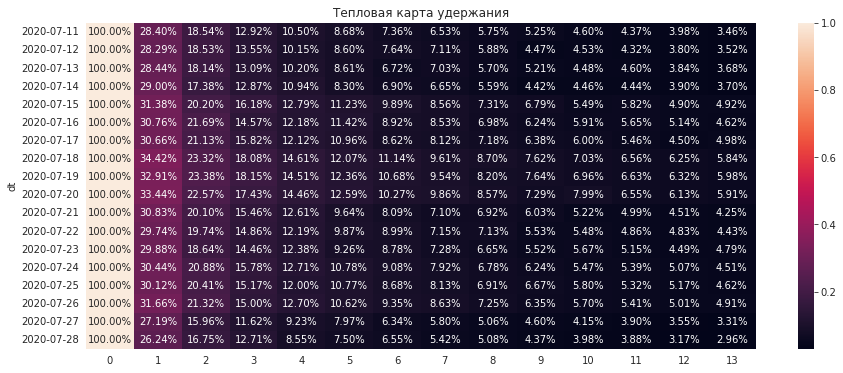

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

# функция для расчёта удержания
def get_retention(
        profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
            result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
        ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped


users = pd.read_csv('datasets/ch02_problems01_users.csv')  # профили
visits = pd.read_csv('datasets/ch02_problems01_visits.csv')  # сессии

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

# доступный интервал привлечения пользователей
min_analysis_date = users['dt'].min()
observation_date = users['dt'].max()  # момент анализа

# горизонт анализа
analysis_horizon = 14

retention_raw, retention =  get_retention(profiles=users,
                                          sessions=visits,
                                          observation_date=observation_date,
                                          horizon_days=analysis_horizon)# получите сырые данные и таблицу удержания

# постройте хитмэп по таблице удержания
plt.figure(figsize = (15, 6))
sns.heatmap(retention.drop(columns=['cohort_size',0]),
            annot=True,
            fmt='.2%') # допишите код
# установите параметры annot=True
# и fmt='.2%'
plt.title('Тепловая карта удержания') # название графика
plt.show()

# 2.
Постройте график, отражающий динамику удержания игроков на конец первой и второй недели — 7-й и 14-й дни.
Помните, что нумерация лайфтаймов начинается с нуля.

Подсказка
Нумерация лайфтаймов начинается с нуля, поэтому данные об удержании 7-го дня хранит столбец 6, а 14-го дня — столбец 13.
Сделайте срез таблицы удержания, указав в квадратных скобках retention список [6, 13].
Вызовите к результату метод plot(), передав параметру grid значение True, а параметру figsize — (15, 5).

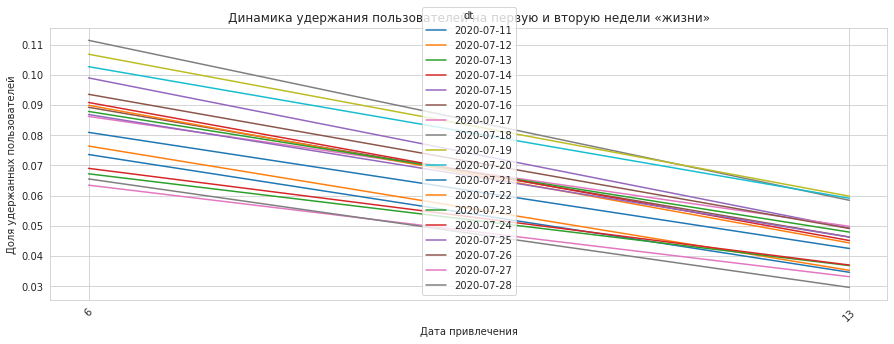

In [16]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

# функция для расчёта удержания
def get_retention(
        profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
            result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
        ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped


users = pd.read_csv('datasets/ch02_problems01_users.csv')  # профили
visits = pd.read_csv('datasets/ch02_problems01_visits.csv')  # сессии

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

# доступный интервал привлечения пользователей
min_analysis_date = users['dt'].min()
observation_date = users['dt'].max()  # момент анализа

# горизонт анализа
analysis_horizon = 14

retention_raw, retention = get_retention(
    users, visits, observation_date, analysis_horizon
)
report = retention.drop(columns=['cohort_size', 0])[[6, 13]]
report.T.plot(grid=True,
              xticks=list(report.columns.values),
              figsize=(15,5))
# постройте график истории изменений для 7-го и 14-го дней
# добавьте на график сетку, задав параметр grid
# установите размер графика 15 на 5, задав параметр figsize

plt.title('Динамика удержания пользователей на первую и вторую недели «жизни»')
plt.xlabel('Дата привлечения')
plt.xticks(rotation = 45)
plt.ylabel('Доля удержанных пользователей')
plt.show()